In [1]:
import scanpy as sc
from pathlib import Path
import numpy as np
from utils import *
import torch
import random
from config import set_arg
from model_train import *

import sys
sys.argv = ['run.py']

# the location of R, please relpace R_HOME and R_USER to your local R installation paths before running. 
os.environ['R_HOME'] = '/home/zhangzixuan/miniconda3/envs/hyper/lib/R'
os.environ['R_USER'] = '/home/zhangzixuan/miniconda3/envs/hyper/lib/python3.9/site-packages/rpy2'


opt = set_arg()
args = opt.parse_args()
seed=args.seed
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8' 


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('===== Using device: ' + 'cuda:0' if torch.cuda.is_available() else 'cpu')
args.device = device

===== Using device: cuda:0


In [2]:
### load data
BASE_PATH = Path('/data/zhangzixuan/HyperST/Data')
sample='151509'
args.n_domains=7
adata = sc.read_visium(BASE_PATH / sample)
adata.var_names_make_unique()
adata1=adata.copy()
adata=preprocess_data(adata)

/home/zhangzixuan/miniconda3/envs/hyper/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/zhangzixuan/miniconda3/envs/hyper/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
args

Namespace(seed=2024, latent_dim=50, hidden_dim1=50, hidden_dim2=50, epochs=200, lr=0.0001, weight_decay=0.0005, tol=0.0, init='mclust', radius=50, knn=6, n_domains=7, mode_knn='knn', update_interval=10, first_aggregate='mean', device=device(type='cuda', index=0))

In [4]:
# incidence matrix --- attribute
H_gene,X_svgs= construct_H_from_attribute_matrix(adata1)

## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 4789 
## number of total genes: 17543 
## Running with single core, may take some time 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5


In [5]:
### incidence matrix --- structure
data_loc = adata.obsm['spatial'].astype(np.float32)
data_dismat = pairwise_distance(data_loc)
H_spatial=construct_H_with_KNN_from_distance(data_dismat,method='knn',k_neig=args.knn)

In [6]:
adata_X = sc.pp.pca(adata, n_comps=args.latent_dim)

In [7]:
HyperST_model=HyperSTModel_Train(adata,H_gene,H_spatial,params=args,init=args.init,datatype='10X')
HyperST_model.training_model()

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



Initializing cluster centers with mclust
fitting ...
  |======================================================================| 100%


Epoch: 100%|██████████| 200/200 [00:10<00:00, 19.97it/s, loss=2.394106] 


In [8]:
y_pred,latent_z,prob=HyperST_model.predict()
adata.obs["clustering"] = y_pred
adata.obs["clustering"] = adata.obs["clustering"].astype('category')
adata.obsm['HyperST'] = latent_z

In [9]:
ann_df_path = f'/data/zhangzixuan/HyperST/Data/DLPFC_annotations/{sample}_truth.txt'
Ann_df = pd.read_csv(ann_df_path, sep='\t', header=None)
Ann_df.columns = ['sample', 'Ground Truth']
Ann_df.set_index('sample', inplace=True)
adata.obs = adata.obs.join(Ann_df)

In [10]:
adata=refine_label(adata,key='clustering')

In [13]:
from sklearn.metrics.cluster import adjusted_rand_score
adata = adata[~pd.isnull(adata.obs['Ground Truth'])]  # 处理缺失值
ARI = adjusted_rand_score(adata.obs['label_refined'], adata.obs['Ground Truth'])
print('Adjusted rand index = %.2f' %ARI)

Adjusted rand index = 0.67


/home/zhangzixuan/miniconda3/envs/hyper/lib/python3.9/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/zhangzixuan/miniconda3/envs/hyper/lib/python3.9/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/zhangzixuan/miniconda3/envs/hyper/lib/python3.9/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/home/zhangzixuan/miniconda3/envs/hyper/lib/python3.9/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


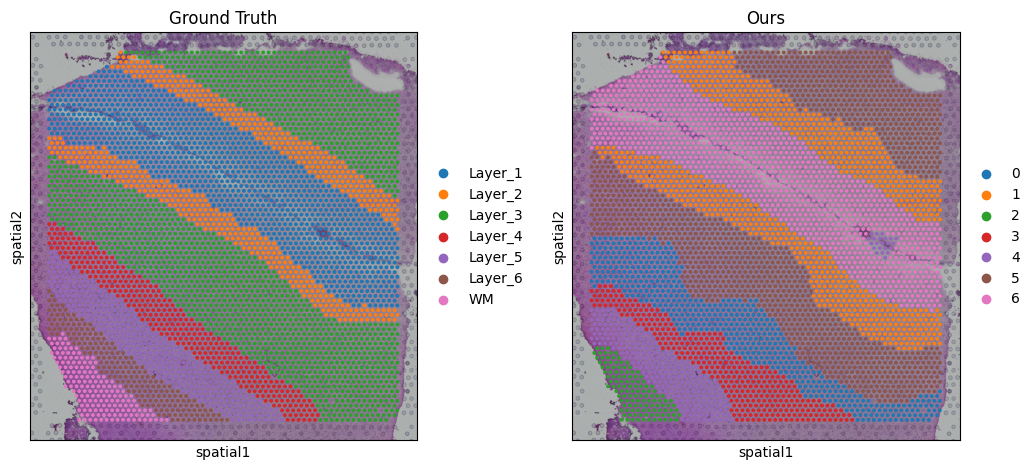

In [12]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sc.pl.spatial(adata, img_key="hires", color='Ground Truth', ax=axes[0], show=False)
axes[0].set_title("Ground Truth")

sc.pl.spatial(adata, img_key="hires", color='label_refined', ax=axes[1], show=False)
axes[1].set_title("Ours")  

plt.subplots_adjust(wspace=0.4)

plt.show()